In [60]:
# Importing required libraries--------------------------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import math

In [61]:
# Defining required constants---------------------------------------------------------------------------------------------------
n = 1000 
epsilon=1e-6
o = 20
# at o = 25 x grid also contain x axis

In [62]:
# Function of camber line obtained from internet--------------------------------------------------------------------------------
def naca_4digit_camber(x, m, p):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if 0 <= x[i] <= p:
            y[i] = m / p**2 * (2 * p * x[i] - x[i]**2)
        else:
            y[i] = m / (1 - p)**2 * ((1 - 2 * p) + 2 * p * x[i] - x[i]**2)
    return y

In [63]:
# Function to generate camber points--------------------------------------------------------------------------------------------
def generate_camber_points(x_values, camber_function):
    
    x_coordinates = np.array(x_values)
    y_coordinates = np.array([camber_function(x) for x in x_values])
    return x_coordinates, y_coordinates

In [64]:
def plots(x,y):
    plt.figure(figsize=(8, 6))
    if choice in ['y','Y']:
        plt.plot(x, y, label=f'NACA Camber Line (m={m_input}, p={p_input})', color='blue')
        plt.title('Camber Line for NACA 4-digit Series Airfoil')
    
    elif choice in ['n','N']:
        plt.plot(x, y, label='User-Defined Camber Line', color='green')
        plt.title('User-Defined Camber Line')
    
    plt.xlim(-1.5,2.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel('x-coordinate (Chord)')
    plt.ylabel('y-coordinate (Camber)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [65]:
# Function to find the slope at anypoint on the camber line for NACA foils------------------------------------------------------
def camber_slope(x, m, p):
    
    if 0 <= x <= p:
        return m / p**2 * (2 * p  - 2 * x)
    else:
        return m / (1 - p)**2 * (2 * p - 2 * x)

In [66]:
# Function to find the slope at anypoint on the camber line for user defined foils----------------------------------------------
def camber_slope_user(x, custom_camber, epsilon=1e-6):
   
    y1 = custom_camber(x - epsilon)
    y2 = custom_camber(x + epsilon)
    slope = (y2 - y1) / (2 * epsilon)

    return slope

In [67]:
def thetas():
    theta = np.zeros(n)

    for i in range(n):
        theta[i] = np.arccos((1-2*x_values[i]))
    
    dtheta = np.zeros(n)

    for i in range(n-1):
        dtheta[i] = theta[i+1] - theta[i]

    dtheta[n-1] = 3e-14
    
    return theta,dtheta
    

In [68]:
# Function to calculate A_not---------------------------------------------------------------------------------------------------
def A_not(alpha,s):
    
    theta,dtheta = thetas()
    A0_sum = 0
    for i in range(n):
        A0_sum = A0_sum + s[i]*dtheta[i]

    A0 = alpha - A0_sum/np.pi

    return A0
# It returns the value of A_not.

In [69]:
# Function to calculate values of A_n except A_not------------------------------------------------------------------------------
def An(alpha,s):
    
    theta,dtheta = thetas()
    Ao = A_not(alpha,s)
    
    A = np.zeros(n+1)
    for i in range(n+1):
        if i == 0:
            A[i] = Ao
        else:
            for j in range(n):
                A[i] = A[i] + s[j]*dtheta[j]*np.cos((i)*theta[j])
            A[i] = (2*A[i])/np.pi
    
    return A

In [70]:
# Function to compute coefficient of lift using values of A_not and A_1---------------------------------------------------------
def coeff_lift(alpha,s):
    A = An(alpha,s)
    cl = np.pi*(2*A[0] + A[1])
    return cl

In [71]:
# Function to compute coefficient of moment-------------------------------------------------------------------------------------
def cm(alpha,s):
    cm = np.pi/2*(-1)*(A[0] + A[1]-A[2]/2)
    return cm

In [72]:
# Function to plot vector plot of the velocities around a thin airfoil----------------------------------------------------------
def streamlines(vel,A,x_values,y_values,choice):

    theta,dtheta = thetas()
    An_sum = np.zeros(n+1)
    
    for i in range(n):
        for j in range(n+1):
            if j == 0:
                continue
            else:
                An_sum[i] = An_sum[i] + A[j]*np.sin((j)*theta[i])

# Calculating values of gamma (strength of vortices at small segments of airfoil).            
    gamma = np.zeros(n)

    for i in range(n):
        if np.sin(theta[i]) == 0:
            continue
        
        else:
            gamma[i] = 2*vel*(A[0]*(1+np.cos(theta[i]))/np.sin(theta[i]) + An_sum[i])
    
    gamma[0] = gamma[n-1]
    
# Creating grid to plot velocities
    x_box = np.linspace(-1.5, 2.5, o)
    y_box = np.linspace(-1.5, 1.5, o)
    x_mesh, y_mesh = np.meshgrid(x_box, y_box)

    v_x = np.zeros((o,o))
    v_y = np.zeros((o,o))
    r_x = np.zeros(n)
    r_y = np.zeros(n)
    r = np.zeros(n)
    ds = np.zeros(n)
    for i in range(o):
        for k in range(o):
            for j in range(n):
                r_x[j] = -x_mesh[k][i] + x_values[j] 
                r_y[j] = y_mesh[k][i] - y_values[j]
                r[j] = math.sqrt(r_x[j]*r_x[j] + r_y[j]*r_y[j])
                
                if choice in ['y','Y']:
                    ds[j] = math.sqrt(1+camber_slope(x_values[j],m_input,p_input)**2)*(dx[j]) 
                elif choice in ['n','N']:
                    ds[j] = math.sqrt(1+camber_slope_user(x_values[j], custom_camber)**2)*(dx[j])
    
                v_x[k][i] = v_x[k][i] + (((r_y[j]) * gamma[j]*ds[j])/(2*np.pi*r[j]**2))
                v_y[k][i] = v_y[k][i] + (((r_x[j]) * gamma[j]*ds[j])/(2*np.pi*r[j]**2))

# Making components of free stream velocities to add them with induced velocity.
    u_x = vel*np.cos(alpha)
    u_y = vel*np.sin(alpha)

    for i in range(o):
        for j in range(o):
            v_x[j][i] = v_x[j][i] + u_x
        
    for i in range(o):
        for j in range(o):
            v_y[j][i] = v_y[j][i] + u_y

    plt.figure(figsize=(8, 6))
    plt.quiver(x_mesh, y_mesh, v_x, v_y, scale=1000,width = 0.002, color='black', pivot='mid')
    
    if choice in ['y','Y']:
        plt.plot(x_values, y_values, label=f'NACA Camber Line (m={m_input}, p={p_input})', color='blue')
        plt.title('Camber Line for NACA 4-digit Series Airfoil')
    
    elif choice in ['n','N']:
        plt.plot(x_values, y_values, label='User-Defined Camber Line', color='green')
        plt.title('User-Defined Camber Line')
    
    plt.plot(x_values, y_values, label=f'NACA Camber Line (m={m_input}, p={p_input})', color='blue')
    plt.title('Vector Field around Airfoil')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.show()
    return gamma,x_box,y_box,v_x,v_y,ds
# Returning values of gamma , grind points and net velocities at grid points so we can store them in globaly

In [73]:
# Function to calculate circulation using circulation distribution along camber line.-------------------------------------------
def circul(gamma,ds):
    g = 0
    theta,dtheta = thetas()
    for i in range(n):
        g = g + gamma[i]*ds[i]
    return g

In [74]:
#Function to compute circulation using velocity line-integral approach about a rectangular region.----------------------------
def line_integral(v_x, v_y, x_box, y_box):
    integral = 0.0
    for i in range(len(x_box)-1):
        # Integrate along the bottom edge
        integral +=  (1)*(v_x[-1][i]) * abs(x_box[i+1] - x_box[i])

        # Integrate along the top edge
        integral +=  (-1)*(v_x[0][i]) * abs(x_box[i+1] - x_box[i])
    
    for j in range(len(y_box)-1):
        # Integrate along the left edge
        integral += (1)*(v_y[j][0]) * abs(y_box[j+1] - y_box[j])
        # Integrate along the right edge
        integral += (-1)*(v_y[j][-1]) * abs(y_box[j+1] - y_box[j])
    
    return integral

Do you want to use a NACA airfoil camber line? (Y for yes/N for no): y
Enter the maximum camber as a fraction of chord: 0.073
Enter the position of maximum camber as a fraction of chord: 0.475


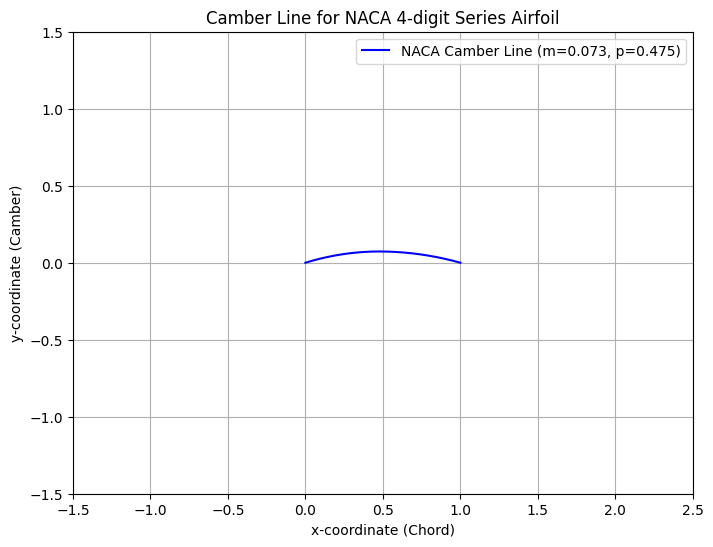

In [75]:
# Main function starts here-----------------------------------------------------------------------------------------------------

choice = input("Do you want to use a NACA airfoil camber line? (Y for yes/N for no): ").lower()

# For ploting NACA series.
x_values = np.linspace(0, 1, n)
if choice in ['y','Y']:
    # User input for NACA 4-digit series airfoil parameters
    m_input = float(input("Enter the maximum camber as a fraction of chord: "))
    p_input = float(input("Enter the position of maximum camber as a fraction of chord: "))

    # Generate and plot points along the camber line for the NACA 4-digit series airfoil
    y_values = naca_4digit_camber(x_values, m_input, p_input)
    plots(x_values,y_values)

# For ploting user defined airfoil.
    
elif choice in ['n','N']:
    # User-defined camber line function
    custom_equation = input("Enter your custom camber line equation as a valid Python expression in terms of 'x': ")
    
    # Define the custom camber function using the user's input
    custom_camber = lambda x: eval(custom_equation, {'x': x})
    x_values, y_values = generate_camber_points(x_values, custom_camber)
    plots(x_values,y_values)

else:
    print("Invalid choice. Please enter 'yes' or 'no'.")

dx = np.zeros(n)   
for i in range(n-1):
    dx[i] = x_values[i+1] - x_values[i]
dx[n-1] = dx[n-2]

In [76]:
# Asking for input from user to compute slope

input_x = float(input("Enter the x-coordinate along the chord to find the slope: "))

if choice in ['y','Y']:
    slope = camber_slope(input_x, m_input, p_input)
    print("slope at x = ",input_x,"is",slope)
    
elif choice in ['n','N']:
    slope = camber_slope_user(input_x, custom_camber)
    print("slope at x = ",input_x,"is",slope)

Enter the x-coordinate along the chord to find the slope: 0.2
slope at x =  0.2 is 0.1779501385041551


In [77]:
# Here we are calculating slope at each point of camber and finding coefficient of lift at a particular angle of attack.--------

alpha = float(input("Enter the angle of attack in degrees: "))
alpha = np.radians(alpha)

s = np.zeros(n)
if choice in ['y','Y']:
    for i in range(n):
        s[i] = camber_slope(x_values[i], m_input, p_input)

elif choice in ['n','N']:
    for i in range(n):
            s[i] = camber_slope_user(x_values[i], custom_camber)
    
cl = coeff_lift(alpha,s)
print ("coefficient of lift",cl)

Enter the angle of attack in degrees: 3
coefficient of lift 1.2205079397638618


Enter freestream velocity: 30


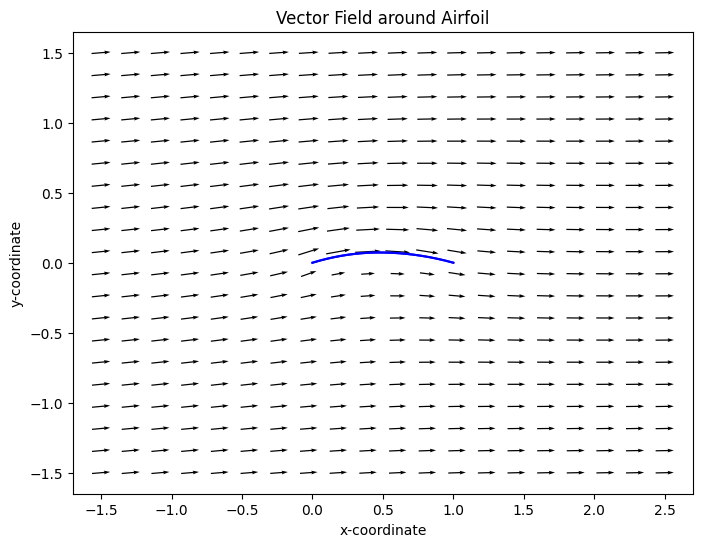

In [78]:
# Ploting vector field and asking for inout of free stream velocity.------------------------------------------------------------
A = An(alpha,s)
u = float(input("Enter freestream velocity: "))
gamma,x_box,y_box,v_x,v_y,ds = streamlines(u,A,x_values,y_values,choice)
# Taking multiple returns and storing values in global variables.

In [79]:
# Computing circulation using circulation distribution along camber line.-------------------------------------------------------
print("circulation :",circul(gamma,ds))


circulation : 18.423222441629882


In [80]:
# Computing circulation using velocity line-integral approach about a rectangular region.---------------------------------------

integral_result = line_integral(v_x, v_y, x_box, y_box)
print("Line Integral Result:", integral_result)

Line Integral Result: 18.41856860316916


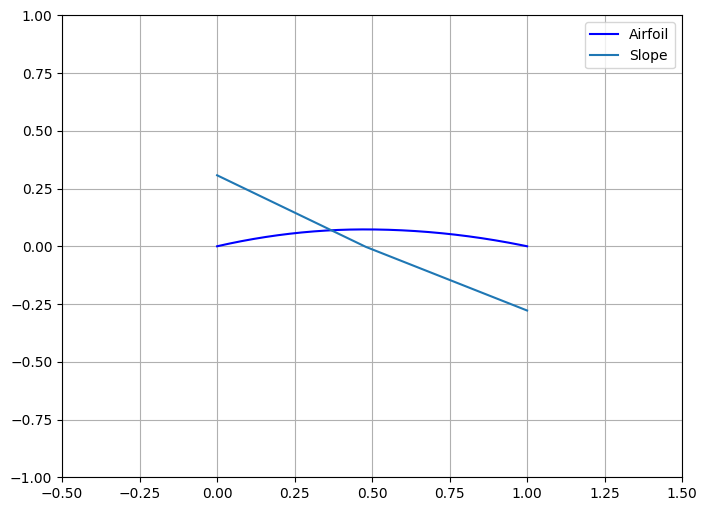

In [81]:
# Ploting slope about camber.---------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=f'NACA Camber Line (m={m_input}, p={p_input})', color='blue')
plt.xlim(-0.5,1.5)
plt.ylim(-1,1)
plt.plot(x_values,s)
plt.grid(True)
plt.legend(["Airfoil", "Slope"])

In [82]:
# Computing values of coefficient of lift for range of alpha.-------------------------------------------------------------------
r = 10
CL = np.zeros(r)
alpha_min = float(input("Enter minimum angle of attack in degrees: "))
alpha_max = float(input("Enter maximum angle of attack in degrees: "))
Alpha = np.array(np.linspace(alpha_min,alpha_max,r))
the = Alpha*(np.pi/180)
for i in range(r):
    CL[i] = coeff_lift(the[i],s)
    
print("done")

Enter minimum angle of attack in degrees: -4
Enter maximum angle of attack in degrees: 10
done


In [83]:
# CFD simulation data of NACA 7411 from assigment 1.----------------------------------------------------------------------------

cfd_cl = [3.81e-01,5.97e-01,8.09e-01,1.02e+00,1.12e+00,1.22e+00,1.40e+00,1.57e+00,1.72e+00]
cfd_alpha = [-4,-2,0,2,3,4,6,8,10]

Text(0, 0.5, 'Coefficient of Lift (Cl)')

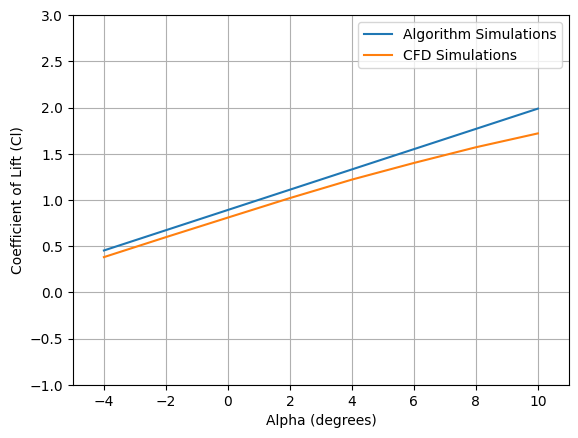

In [84]:
# Plotting Cl vs Alpha for both algorith simulations and CFD simulations.-------------------------------------------------------

plt.plot(Alpha,CL)
plt.plot(cfd_alpha,cfd_cl)
plt.grid(True)
plt.legend(["Algorithm Simulations","CFD Simulations"])
plt.xlim(-5,11)
plt.ylim(-1,3)
plt.xlabel("Alpha (degrees)")
plt.ylabel("Coefficient of Lift (Cl)")

In [85]:
def final_fun(choice,m_input,p_input,x_s,aoa,v):
    x_values = np.linspace(0,1,n)
    s = np.zeros(n)
    A = np.zeros(n)
    if choice in ['y','Y']:
        y_values = naca_4digit_camber(x_values, m_input, p_input)
        plots(x_values,y_values)
        slope = camber_slope(x_s, m_input, p_input)
        print("slopes at x = ",x_s, "is",slope)
        for i in range(n):
            s[i] = camber_slope(x_values[i], m_input, p_input)  
    elif choice in ['n','N']:
        x_values, y_values = generate_camber_points(x_values, custom_camber)
        plots(x_values,y_values)
        slope = camber_slope_user(x_s, custom_camber)
        print(slope)
        for i in range(n):
            s[i] = camber_slope_user(x_values[i], custom_camber)
    else:
        print("Invalid choice. Please enter 'yes' or 'no'.")
    A = An(aoa,s)
    cl = coeff_lift(aoa,s)
    print ("coefficient of lift",cl)
    gamma,x_box,y_box,v_x,v_y,ds = streamlines(v,A,x_values,y_values,choice)
    print("circulation :",circul(gamma,ds))
    integral_result = line_integral(v_x, v_y, x_box, y_box)
    print("Line Integral Result:", integral_result)

Do you want to use a NACA airfoil camber line? (Y for yes/N for no): y
Enter the maximum camber as a fraction of chord: 0.02
Enter the position of maximum camber as a fraction of chord: 0.4
Enter the angle of attack in degrees: 3
Enter freestream velocity: 30
Enter the x-coordinate along the chord to find the slope: 0.2


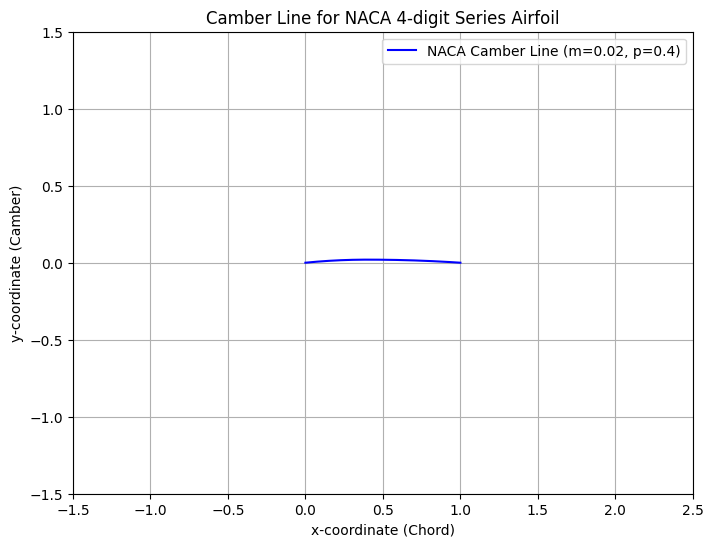

slopes at x =  0.2 is 0.04999999999999999
coefficient of lift 0.5563923797905175


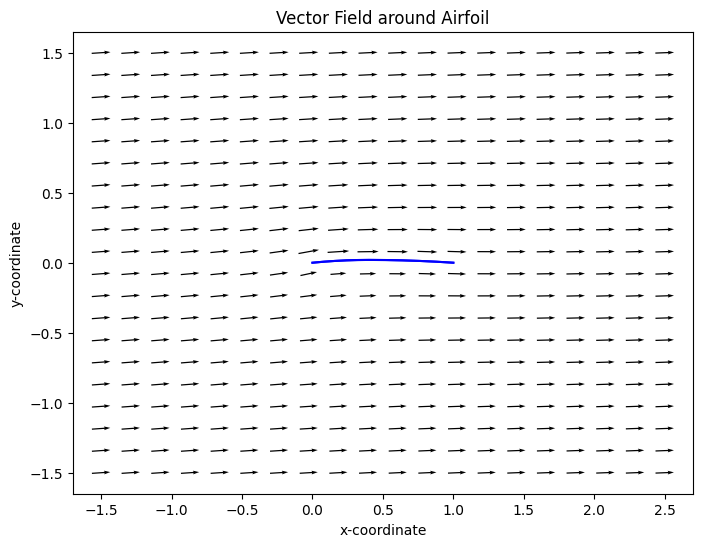

circulation : 8.227481411623513
Line Integral Result: 8.234749605808963


In [86]:
# Main function starts here-----------------------------------------------------------------------------------------------------

choice = input("Do you want to use a NACA airfoil camber line? (Y for yes/N for no): ").lower()

# For ploting NACA series.

if choice in ['y','Y']:
    # User input for NACA 4-digit series airfoil parameters
    m_input = float(input("Enter the maximum camber as a fraction of chord: "))
    p_input = float(input("Enter the position of maximum camber as a fraction of chord: "))
elif choice in ['n','N']:
    # User-defined camber line function
    custom_equation = input("Enter your custom camber line equation as a valid Python expression in terms of 'x': ")
    
    # Define the custom camber function using the user's input
    custom_camber = lambda x: eval(custom_equation, {'x': x})
alpha = np.radians(float(input("Enter the angle of attack in degrees: ")))
u = float(input("Enter freestream velocity: "))
input_x = float(input("Enter the x-coordinate along the chord to find the slope: "))
dx = np.zeros(n)   
for i in range(n-1):
    dx[i] = x_values[i+1] - x_values[i]
dx[n-1] = 0.001

final_fun(choice,m_input,p_input,input_x,alpha,u)

In [87]:
custom_equation_1 = input("Enter your custom camber line equation as a valid Python expression in terms of 'x': ")
custom_camber_1 = lambda x: eval(custom_equation_1, {'x': x})
x_1, y_1 = generate_camber_points(x_values, custom_camber_1)

Enter your custom camber line equation as a valid Python expression in terms of 'x': -x*(x-1)**3


In [88]:
custom_equation_2 = input("Enter your custom camber line equation as a valid Python expression in terms of 'x': ")
custom_camber_2 = lambda x: eval(custom_equation_2, {'x': x})
x_2, y_2 = generate_camber_points(x_values, custom_camber_2)

Enter your custom camber line equation as a valid Python expression in terms of 'x': 2*x*(x-1/3)*(x-1)


In [89]:
custom_equation_3 = input("Enter your custom camber line equation as a valid Python expression in terms of 'x': ")
custom_camber_3 = lambda x: eval(custom_equation_3, {'x': x})
x_3, y_3 = generate_camber_points(x_values, custom_camber_3)

Enter your custom camber line equation as a valid Python expression in terms of 'x': -x*(x-1)


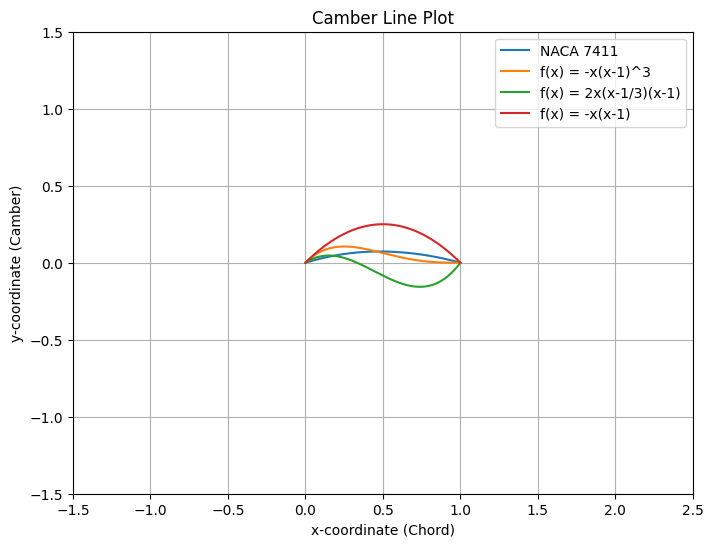

In [90]:

plt.figure(figsize=(8, 6))
plt.plot(x_values,y_values)
plt.plot(x_1,y_1)
plt.plot(x_2,y_2)
plt.plot(x_3,y_3)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,1.5)
plt.xlabel('x-coordinate (Chord)')
plt.ylabel('y-coordinate (Camber)')
plt.legend(["NACA 7411","f(x) = -x(x-1)^3","f(x) = 2x(x-1/3)(x-1)","f(x) = -x(x-1)"])
plt.title("Camber Line Plot")
plt.grid(True)
plt.show()

In [91]:
s_1 = np.zeros(n)

for i in range(n):
    s_1[i] = camber_slope_user(x_values[i], custom_camber_1)

In [92]:
s_2 = np.zeros(n)

for i in range(n):
    s_2[i] = camber_slope_user(x_values[i], custom_camber_2)

In [93]:
s_3 = np.zeros(n)

for i in range(n):
    s_3[i] = camber_slope_user(x_values[i], custom_camber_3)

In [94]:
r = 10
CL_1 = np.zeros(r)
alpha_min = float(input("Enter minimum angle of attack in degrees: "))
alpha_max = float(input("Enter maximum angle of attack in degrees: "))
Alpha = np.array(np.linspace(alpha_min,alpha_max,r))
the = Alpha*(np.pi/180)
for i in range(r): 
    CL_1[i] = coeff_lift(the[i],s_1)

print("done")

Enter minimum angle of attack in degrees: -4
Enter maximum angle of attack in degrees: 10
done


In [95]:
CL_2 = np.zeros(r)
for i in range(r):
    CL_2[i] = coeff_lift(the[i],s_2)

In [96]:
CL_3 = np.zeros(r)
for i in range(r):
    CL_3[i] = coeff_lift(the[i],s_3)

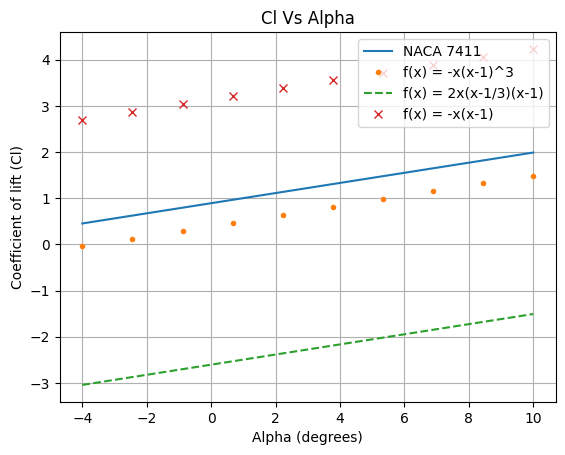

In [97]:
#plt.figure(figsize=(8, 6))
plt.plot(Alpha,CL)
plt.plot(Alpha,CL_1,'.')
plt.plot(Alpha,CL_2,'--')
plt.plot(Alpha,CL_3,'x')
#plt.xlim(-1.5,2.5)
#plt.ylim(-1.5,1.5)
plt.xlabel('Alpha (degrees)')
plt.ylabel('Coefficient of lift (Cl)')
plt.legend(["NACA 7411","f(x) = -x(x-1)^3","f(x) = 2x(x-1/3)(x-1)","f(x) = -x(x-1)"])
plt.grid(True)
plt.title("Cl Vs Alpha")
plt.show()

In [98]:
phi = np.radians(float(input("Enter the angle of attack in degrees: ")))
A_1 = An(phi,s_1)
A_2 = An(phi,s_2)
A_3 = An(phi,s_3)

Enter the angle of attack in degrees: 3


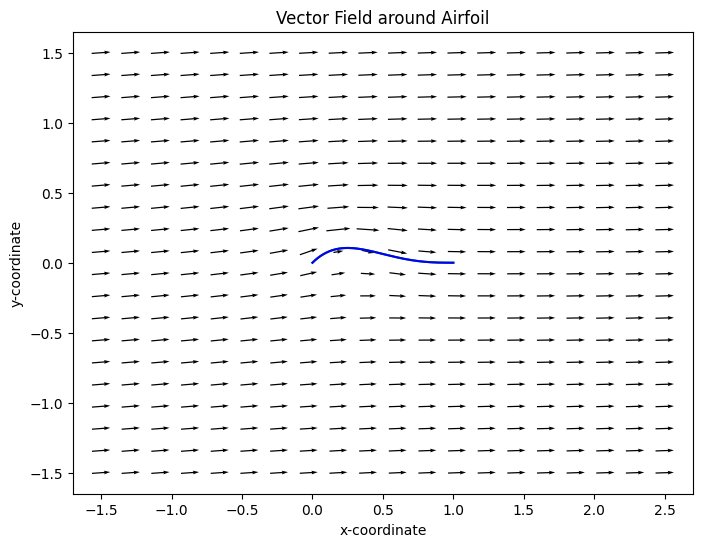

In [100]:
u_inf = 30
z = "n"
custom_camber = custom_camber_1
gamma_1,x_box,y_box,v_x,v_y,ds_1 = streamlines(u_inf,A_1,x_1,y_1,z)

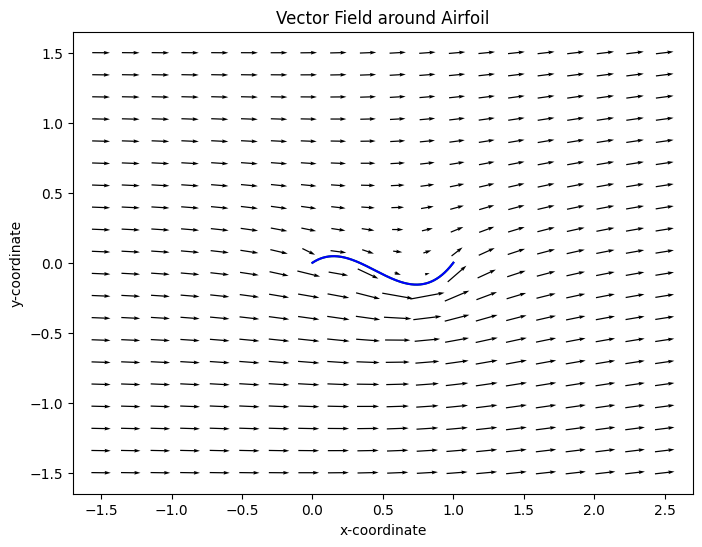

In [103]:
custom_camber = custom_camber_2
gamma_2,x_box,y_box,v_x,v_y,ds_2 = streamlines(u_inf,A_2,x_2,y_2,z)

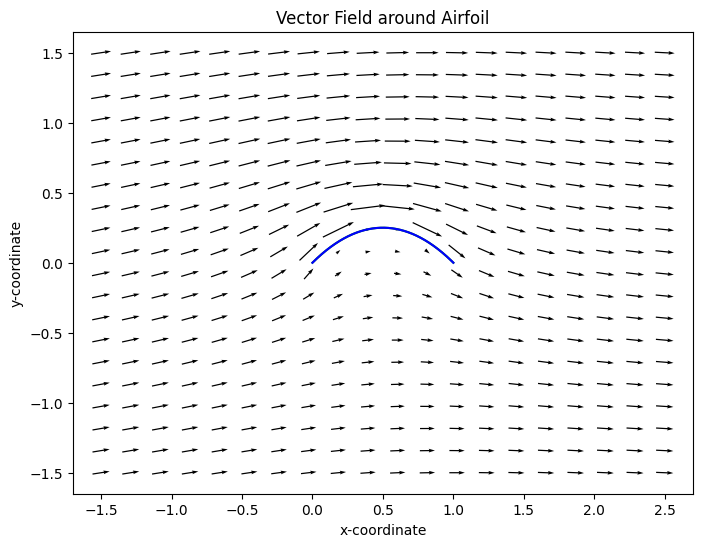

In [104]:
custom_camber = custom_camber_3
gamma_3,x_box,y_box,v_x,v_y,ds_3 = streamlines(u_inf,A_3,x_3,y_3,z)